### Loading data

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_dir = pathlib.Path('/home/henrik/master-thesis/data/hyper-kvasir/labeled/')

ds_size = len(list(data_dir.glob('*/*.*g')))
print (ds_size)

BATCH_SIZE = 128
IMG_HEIGHT = 64
IMG_WIDTH = 64
num_classes = 23

10662


In [5]:
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != '*.txt'])
class_names

array(['barretts-short-segment', 'bbps-0-1', 'impacted-stool', 'bbps-2-3',
       'hemorrhoids', 'ulcerative-colitis-grade-2', 'normal-z-line',
       'retroflex-stomach', 'esophagitis-b-d', 'dyed-resection-margins',
       'ileum', 'ulcerative-colitis-0-1', 'dyed-lifted-polyps', 'polyps',
       'ulcerative-colitis-2-3', 'ulcerative-colitis-1-2',
       'ulcerative-colitis-grade-3', 'retroflex-rectum', 'esophagitis-a',
       'ulcerative-colitis-grade-1', 'pylorus', 'cecum', 'barretts'],
      dtype='<U26')

In [6]:
# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)

In [7]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # get class integer from class-list
    label_int = tf.reduce_min(tf.where(parts[-2] == class_names))
    # cast to tensor array with dtype=uint8
    return tf.dtypes.cast(label_int, tf.int32)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Set 'num_parallel_calls' so multiple images are loaded and processed in parallel
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

### Prepare dataset for training
Want the data to be shuffled and batched. Here we use the `tf.data` api.

In [8]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=100):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(labeled_ds, cache="../hyper-kvasir/cache/reject_resample_test")

In [9]:
for batch in train_ds.take((ds_size//BATCH_SIZE)+1):
    pass

# Balancing the data

## Sample from dataset
Works alright, but reads the dataset num_classes times - so not very efficient

In [40]:
certainty_bs = 20

### Counting functions
def count(counts, batch):
    images, labels = batch

    for i in range(num_classes):
        counts['class_{}'.format(i)] += tf.reduce_sum(tf.cast(labels == i, tf.int32))

    return counts

def count_samples(count_ds):
    count_ds = count_ds.batch(1024)
    # Set the initial states to zero
    initial_state = {}
    for i in range(num_classes):
        initial_state['class_{}'.format(i)] = 0

    counts = count_ds.take(certainty_bs).reduce(
                initial_state = initial_state,
                reduce_func = count)

    final_counts = []
    for class_, value in counts.items():
                final_counts.append(value.numpy().astype(np.float32))

    final_counts = np.asarray(final_counts)
    fractions = final_counts/final_counts.sum()
    return fractions

In [9]:
initial_dist = count_samples(train_ds.unbatch())
target_dist = [1.0/num_classes] * num_classes

print (initial_dist)

[0.00517578 0.06308594 0.01279297 0.11210938 0.00058594 0.01503906
 0.09101562 0.07460938 0.02539062 0.09658203 0.00087891 0.00341797
 0.09785156 0.10039063 0.00273437 0.00107422 0.         0.03818359
 0.03935547 0.01962891 0.0975586  0.09853516 0.00400391]


In [10]:
datasets = []
for i in range(num_classes):
    ds = train_ds.unbatch().filter(lambda image, label: label==i).repeat()
    datasets.append(ds)

In [11]:
balanced_ds = tf.data.experimental.sample_from_datasets(datasets, target_dist)

In [12]:
print (count_samples(balanced_ds))

[0.04599609 0.04042969 0.04228516 0.04248047 0.04277344 0.04208984
 0.04755859 0.04355469 0.04726563 0.04335938 0.04042969 0.04335938
 0.0428711  0.04248047 0.04267578 0.03964844 0.04492188 0.04150391
 0.04619141 0.04326172 0.04550781 0.04482422 0.04453125]


## Rejection resampling
Somehow seems to work-ish if all shuffling of data is disabled, but still gives weird results..

In [45]:
resample_ds = train_ds.unbatch().apply(
        tf.data.experimental.rejection_resample(
            class_func=lambda image, label: label,
            target_dist=target_dist,
            initial_dist=initial_dist,
            seed=21))

extra_label: ulcerative-colitis-grade-3
image and label: ulcerative-colitis-grade-3


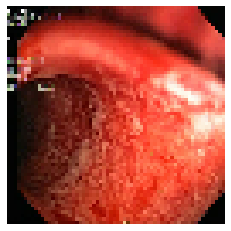

In [46]:
for extra_label, image_and_label in resample_ds.take(1):
    print ("extra_label:",class_names[extra_label.numpy()])
    print ("image and label:", class_names[image_and_label[1].numpy()])
    show_image(image_and_label[0])

In [23]:
# drop the extra labels (which should just be a copy)
balanced_ds = resample_ds.map(lambda extra_label, img_and_label: img_and_label)

In [ ]:
for image, label in balanced_ds_reject.take(2):
    print (class_names[label.numpy()])
    show_image(image)

In [41]:
print (count_samples(balanced_ds_reject))

[2.6367188e-03 3.3203125e-02 4.8828125e-03 5.1367186e-02 2.9296876e-04
 7.7148438e-03 3.3496093e-02 1.6943360e-02 1.0058594e-02 4.0527344e-02
 3.4179687e-04 6.3476560e-04 4.1992188e-02 3.4033202e-02 4.3945311e-04
 2.4414062e-04 6.1733401e-01 9.5214844e-03 1.5722657e-02 4.2968751e-03
 2.9443359e-02 4.2822264e-02 2.0507812e-03]
